Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 csv-файла:

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode

import scipy.stats as stats
from scipy.stats import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

## Data

In [2]:
def get_data(public_key: str, sep: str) -> pd.DataFrame:
    '''
    Загружает csv-файл с яндекс диска и возвращает его в виде pandas DataFrame.

    Параметры:
    - public_key: Публичная ссылка на файл на яндекс диске.
    - sep: Разделитель в csv-файле.

    Возвращает:
    - pd.DataFrame: Датафрейм с данными из csv-файла.
    '''
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, sep=sep)

In [3]:
active_studs = get_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', sep=',')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [4]:
checks = get_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [5]:
group_add = get_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', sep=',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Нерабочая ссылка для groups, использую ссылку для скачивания

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/UhyYx41rTt3clQ'))
response = requests.get(final_url)
response

<Response [404]>

In [7]:
download_link = 'https://s89vlx.storage.yandex.net/rdisk/da8c9bfc9ddef881d71064e03e152e0e863166bf2d9bc9cd55ba81b95cb08bc3/64e7db7d/fKqInKw3d7bLFOeFnMGnhLWIS9AmXMMXWGR17A-BkO3-qg5Wp8tUAp7lxoJJvJyG8pjltSuuxShICmGl2FDiJhbsM4PC04KdB-NoZUjfeOOr8npumZHI4midPdWhecNq?uid=992018421&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_groups.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fplain&owner_uid=992018421&fsize=724984&hid=4b9098e1d545e562c779de19f9f64e2f&media_type=spreadsheet&tknv=v2&etag=6517d04ad247593dab021669e7065354&rtoken=SudwIokDkN1x&force_default=yes&ycrid=na-31a015b7e140e202ed35bdcec299f6d7-downloader4h&ts=603b2dce01940&s=943609a9bd6d3e3a15a4d834f2016177411f1cf91a67f9bdeb6e29f504b070cf&pb=U2FsdGVkX1_swfdPh-FrRXFaOFayOBGLD1Wz1Q8RNN2LiMjR4dRYf9snRG0saQ4ebmovkIjzZLppYzcG5Nuejops5LEXg_CayV-AYRvCjC82h3fl_MqAKM4HzjfEmij7'
groups = pd.read_csv(download_link, sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
active_studs.shape, checks.shape, groups.shape, group_add.shape

((8341, 1), (541, 2), (74484, 2), (92, 2))

In [9]:
active_studs.student_id.nunique(), checks.student_id.nunique(), groups.id.nunique(), group_add.id.nunique()

(8341, 541, 74484, 92)

## Data processing

Присоединим новые данные к основным.

In [10]:
groups = pd.concat([groups, group_add], ignore_index=True)
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [11]:
groups.shape

(74576, 2)

Платящих пользователей, неактивных в указанный период, учитывать не будем.

In [12]:
# платящие активные
checks.query("student_id in @active_studs.student_id.to_list()").shape

(392, 2)

In [13]:
# платящие неактивные
checks.query("student_id not in @active_studs.student_id.to_list()").shape

(149, 2)

Объединим все данные в один датафрейм. 

Первым мерджем оставляем только активных студентов. 

Вторым добавляем плативших активных пользователей.

In [14]:
df = groups.merge(active_studs, left_on='id', right_on='student_id') \
    .merge(checks, on='student_id', how='left') \
    .drop('student_id', axis=1)
df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


Добавим столбец:
- 1 - платил
- 0 - не платил

In [16]:
df['payment'] = (~df['rev'].isna()).astype(int)
df.head()

,id,grp,rev,payment
0,1627,A,990.0,1
1,2085,B,NaN,0
2,2215,B,NaN,0
3,3391,A,NaN,0
4,3401,B,NaN,0


Разделим данные по группам.

In [17]:
grp_a = df.query("grp == 'A'")
grp_a.head()

,id,grp,rev,payment
0,1627,A,990.0,1
3,3391,A,NaN,0
13,109623,A,NaN,0
15,133678,A,NaN,0
23,175944,A,NaN,0


In [18]:
grp_b = df.query("grp == 'B'")
grp_b.head()

,id,grp,rev,payment
1,2085,B,NaN,0
2,2215,B,NaN,0
4,3401,B,NaN,0
5,22994,B,NaN,0
6,26899,B,NaN,0


In [19]:
grp_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 0 to 8338
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1538 non-null   int64  
 1   grp      1538 non-null   object 
 2   rev      78 non-null     float64
 3   payment  1538 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 54.1+ KB


In [20]:
grp_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6803 entries, 1 to 8340
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       6803 non-null   int64  
 1   grp      6803 non-null   object 
 2   rev      314 non-null    float64
 3   payment  6803 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 239.2+ KB


## Analytics

In [21]:
groups.query("grp == 'A'").shape, groups.query("grp == 'B'").shape 

((14693, 2), (59883, 2))

In [22]:
grp_a.shape, grp_b.shape

((1538, 4), (6803, 4))

#### Размеры групп значительно различаются, это может влиять на результаты стат тестов

Определим наиболее подходящие метрики на основе имеющейся информации.
### Метрики:
- **CR** - доля пользователей, которые выполнили целевое действие (в данном случае - совершили оплату)

- **ARPU** - средний доход с пользователя

- **ARPPU** - средний доход на платящего пользователя (то есть клиента)

Посмотрим на графики распределения платежей:
1. График всех активных пользователей
2. График клиентов

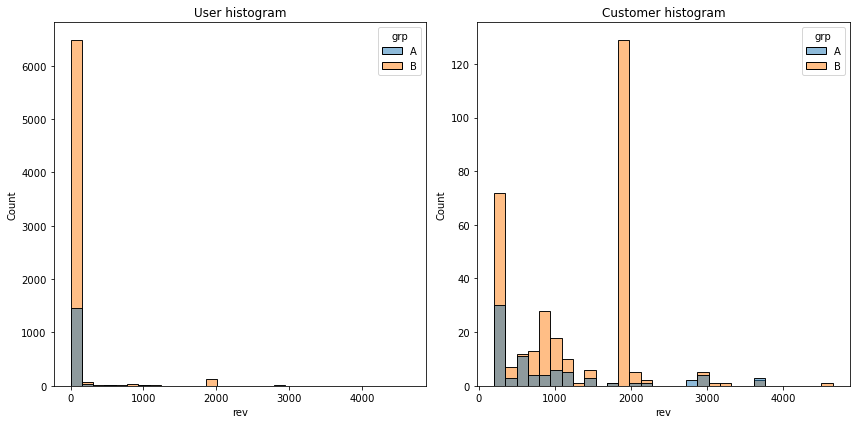

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(data=df, x=df.rev.fillna(0), hue='grp', bins=30, ax=axs[0])
axs[0].set_title('User histogram')

sns.histplot(data=df, x=df.rev, hue='grp', bins=30, ax=axs[1])
axs[1].set_title('Customer histogram')

plt.tight_layout()
plt.show()

### Видно, что распределения не нормальные. Трансформация переменных не помогает и также помним о различных размерах выборок. Наиболее подходящий метод это bootstrap.

In [24]:
def conf_int_plot(means: list, conf_intervals: list):
    '''
    Функция принимает списки средних значений для двух групп и соответствующих 
    им доверительных интервалов, возвращая график, на котором наглядно 
    демонстрируется пересечение этих доверительных интервалов.
    
    means - [mean(Group A), mean(Group B)],
    conf_intervals - [confidence_interval(Group A), confidence_interval(Group B)]
    '''
    
    groups = ['Group A', 'Group B']

    plt.figure(figsize=(10, 5))
    for i, group in enumerate(groups):
        plt.plot(conf_intervals[i], [i, i], color='blue')  # Доверительный интервал
        plt.plot(means[i], i, 'o', color='red')  # Среднее значение
        
        if group == 'Group A':
            plt.axvline(x=conf_intervals[i][0], linestyle='--', color='black')
            plt.axvline(x=conf_intervals[i][1], linestyle='--', color='black')

    plt.yticks(range(len(groups)), groups)
    plt.xlabel('Metric')
    plt.title('Confidence Intervals of metric')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

### CR

In [25]:
grp_a.head()

,id,grp,rev,payment
0,1627,A,990.0,1
3,3391,A,NaN,0
13,109623,A,NaN,0
15,133678,A,NaN,0
23,175944,A,NaN,0


Посмотрим на разницу в конверсии

In [26]:
print(f''' CR:
    Group A - {np.mean(grp_a.payment):.2}% 
    Group B - {np.mean(grp_b.payment):.2}%
''')

 CR:
    Group A - 0.051% 
    Group B - 0.046%



Применим `bootstrap`

In [27]:
int_1 = bootstrap((grp_a.payment, ), np.mean).confidence_interval
int_2 = bootstrap((grp_b.payment, ), np.mean).confidence_interval
int_1, int_2

(ConfidenceInterval(low=0.04031209362808843, high=0.06176853055916775),
 ConfidenceInterval(low=0.041158312509187125, high=0.05115390268998971))

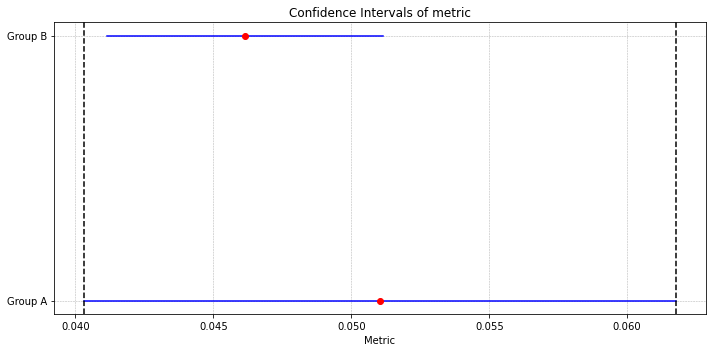

In [28]:
conf_int_plot([np.mean(int_1), np.mean(int_2)], [int_1, int_2])

#### Результаты теста не дали оснований для отклонения нулевой гипотезы о равенстве конверсий.

### ARPU

In [29]:
grp_a.head()

,id,grp,rev,payment
0,1627,A,990.0,1
3,3391,A,NaN,0
13,109623,A,NaN,0
15,133678,A,NaN,0
23,175944,A,NaN,0


Посмотрим на разницу в ARPU

In [30]:
print(f''' ARPU:
    Group A - {np.mean(grp_a.rev.fillna(0))}
    Group B - {np.mean(grp_b.rev.fillna(0))}
''')

 ARPU:
    Group A - 47.34720416124838
    Group B - 58.05879810377776



Применим `bootstrap`

In [31]:
int_1 = bootstrap((grp_a.rev.fillna(0), ), np.mean).confidence_interval
int_2 = bootstrap((grp_b.rev.fillna(0), ), np.mean).confidence_interval
int_1, int_2

(ConfidenceInterval(low=34.772780046334475, high=64.35877330559617),
 ConfidenceInterval(low=50.90499446031293, high=65.83216415574101))

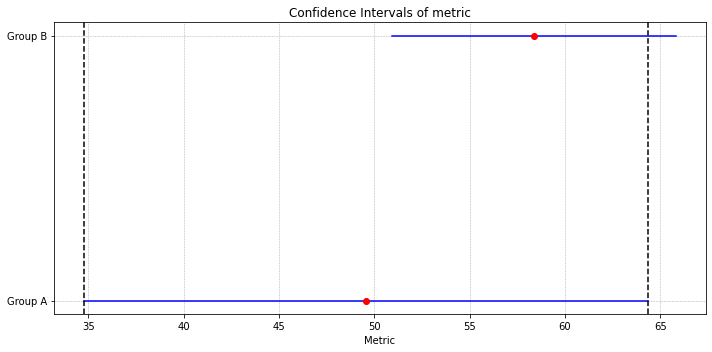

In [32]:
conf_int_plot([np.mean(int_1), np.mean(int_2)], [int_1, int_2])

#### Результаты теста не дали оснований для отклонения нулевой гипотезы о равенстве ARPU.

### ARPPU

In [33]:
grp_a.head()

,id,grp,rev,payment
0,1627,A,990.0,1
3,3391,A,NaN,0
13,109623,A,NaN,0
15,133678,A,NaN,0
23,175944,A,NaN,0


Посмотрим на разницу в ARPPU

In [34]:
print(f''' ARPPU:
    Group A - {np.mean(grp_a.rev.dropna())}
    Group B - {np.mean(grp_b.rev.dropna())}
''')

 ARPPU:
    Group A - 933.5897435897435
    Group B - 1257.878992038217



Применим `bootstrap`

In [35]:
int_1 = bootstrap((grp_a.rev.dropna(), ), np.mean).confidence_interval
int_2 = bootstrap((grp_b.rev.dropna(), ), np.mean).confidence_interval
int_1, int_2

(ConfidenceInterval(low=756.0206893791741, high=1165.3904080718162),
 ConfidenceInterval(low=1171.693123526166, high=1346.8862515849503))

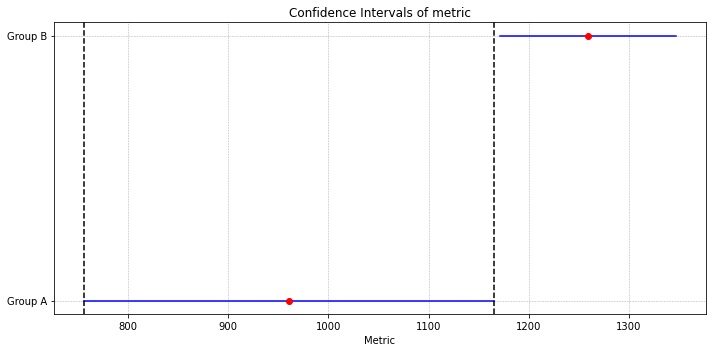

In [36]:
conf_int_plot([np.mean(int_1), np.mean(int_2)], [int_1, int_2])

#### На основе результатов теста можно сделать вывод о статистически значимых различиях и отклонить нулевую гипотезу о равенстве ARPPU.

# <span style="color:lightgreen">Анализ ключевых показателей конверсии (CR) и среднего дохода на пользователя (ARPU) не выявил статистически значимых различий между контрольной и экспериментальной группами. Однако наблюдается статистически значимое увеличение среднего дохода на платящего пользователя (ARPPU) почти на 35%. Это говорит о том, что, несмотря на то что общее количество платящих пользователей осталось неизменным, сумма, которую каждый платящий пользователь тратит в среднем, значительно увеличилась. Исходя из полученных данных, можно рекомендовать внедрение новой механики оплаты для всех пользователей.</span>